# Module 5: Feature Extraction (Algorithmic)

**Owner:** K. Surya Poojith (2022BCD0025)

**Objective:** Extract quantitative shape data from predicted tumor masks: Area, Perimeter, and Centroid. This notebook implements two algorithmic approaches and visualizes the results.

**Notebook tasks:**
- Load a predicted tumor mask (from Module 4 outputs).
- Algorithm 1: compute Area and Perimeter via contours.
- Algorithm 2: compute Centroid via image moments.
- Visualize mask, contour, centroid; print and save results.

_Citations:_ CV Analysis.pdf; 7.Binary image analysis.pdf

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Section 1: Import Required Libraries and Constants
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import csv
import json
from datetime import datetime

# Constants (change as needed)
DEFAULT_PREDICTED_MASK_DIR = Path('/content/drive/MyDrive/kmeans_tumor_masks')  # where Module 4 outputs masks
OUTPUT_FEATURES_CSV = Path('m5_features.csv')
VIS_OUTPUT_DIR = Path('m5_visualizations')
VIS_OUTPUT_DIR.mkdir(exist_ok=True)

# Visualization params
CONTOUR_COLOR = (0, 255, 0)  # green in BGR
CENTROID_COLOR = (255, 0, 0)  # blue in BGR
TEXT_COLOR = (0, 0, 255)      # red in BGR
FIG_DPI = 100

# Reproducibility: set numpy random seed for deterministic synthetic demos
np.random.seed(42)

print('Imports OK. Defaults: predicted mask dir =', DEFAULT_PREDICTED_MASK_DIR)

Imports OK. Defaults: predicted mask dir = /content/drive/MyDrive/kmeans_tumor_masks


In [3]:
# Section 2: Load Predicted Tumor Mask

def load_mask(mask_path: Path, threshold: int = 127) -> np.ndarray:
    """Load a grayscale mask and ensure it's binary (uint8 with 0/255).

    Args:
        mask_path: Path to image file.
        threshold: Threshold to binarize if needed.

    Returns:
        Binary mask as uint8 numpy array (values 0 or 255).
    """
    if not mask_path.exists():
        raise FileNotFoundError(f"Mask file not found: {mask_path}")

    img = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise IOError(f"Failed to read image at: {mask_path}")

    # Ensure binary mask
    _, bin_mask = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    bin_mask = bin_mask.astype(np.uint8)

    print(f"Loaded mask {mask_path.name} shape={bin_mask.shape} dtype={bin_mask.dtype}")
    return bin_mask


def find_example_mask(mask_dir: Path) -> Path:
    """Return one mask path from mask_dir if available, else raise FileNotFoundError."""
    if not mask_dir.exists():
        raise FileNotFoundError(f"Mask directory not found: {mask_dir}")

    # search for typical suffixes produced by Module 4
    candidates = list(mask_dir.rglob('*_tumor_mask.png'))
    if not candidates:
        # fallback to any PNG
        candidates = list(mask_dir.rglob('*.png'))
    if not candidates:
        raise FileNotFoundError(f"No mask files found in directory: {mask_dir}")
    return candidates[0]

# Example usage (commented):
# mask_path = find_example_mask(DEFAULT_PREDICTED_MASK_DIR)
# mask = load_mask(mask_path)


In [4]:
# Section 3: Algorithm 1 - Area and Perimeter via cv2.findContours

def compute_area_perimeter(mask: np.ndarray):
    """Compute area and perimeter from the largest external contour in the binary mask.

    Returns:
        contour (np.ndarray): the largest contour (Nx1x2 array)
        area (float): area in pixel^2
        perimeter (float): perimeter in pixels
    """
    # Find external contours only
    contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, 0.0, 0.0

    # Select the largest contour by area
    areas = [cv2.contourArea(c) for c in contours]
    largest_idx = int(np.argmax(areas))
    largest_contour = contours[largest_idx]

    area = float(cv2.contourArea(largest_contour))
    perimeter = float(cv2.arcLength(largest_contour, True))

    # Citation: contour-based features (see CV Analysis.pdf)
    return largest_contour, area, perimeter

# Quick note: if multiple segmented regions exist, this selects the largest as tumor.


In [5]:
# Section 4: Algorithm 2 - Centroid via cv2.moments

def compute_centroid(mask: np.ndarray, contour: np.ndarray = None):
    """Compute centroid using image moments. If M['m00'] == 0, optionally fall back to contour centroid.

    Returns:
        (cX, cY) tuple of floats or (None, None) if centroid can't be computed.
    """
    M = cv2.moments(mask)
    if M.get('m00', 0) != 0:
        cX = float(M['m10'] / M['m00'])
        cY = float(M['m01'] / M['m00'])
        return cX, cY

    # Fallback: if centroid cannot be computed from moments, use contour centroid
    if contour is not None and len(contour) > 0:
        M_c = cv2.moments(contour)
        if M_c.get('m00', 0) != 0:
            cX = float(M_c['m10'] / M_c['m00'])
            cY = float(M_c['m01'] / M_c['m00'])
            return cX, cY

    return None, None

# Citation: 7.Binary image analysis.pdf


In [6]:
# Section 5: Visualization: Draw Contour and Centroid

def visualize_results(mask: np.ndarray, contour: np.ndarray, centroid, out_name: str = None, figsize=(6,6)):
    """Draw contour and centroid on a color image for visualization and optionally save figure.

    Args:
        mask: binary mask (0/255)
        contour: contour to draw (numpy array) or None
        centroid: (cX, cY) tuple or None
        out_name: filename to save visualization (under VIS_OUTPUT_DIR)
    """
    # Convert mask to BGR color for drawing
    canvas = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    if contour is not None:
        cv2.drawContours(canvas, [contour], -1, CONTOUR_COLOR, 2)

    if centroid is not None and centroid[0] is not None:
        cx, cy = int(round(centroid[0])), int(round(centroid[1]))
        cv2.circle(canvas, (cx, cy), 5, CENTROID_COLOR, -1)
        # Annotate coordinates
        cv2.putText(canvas, f"c=({cx},{cy})", (cx+8, cy-8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, TEXT_COLOR, 1)

    # Show with matplotlib (convert BGR->RGB)
    rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(rgb)
    plt.axis('off')

    if out_name:
        out_path = VIS_OUTPUT_DIR / out_name
        plt.savefig(out_path, dpi=FIG_DPI, bbox_inches='tight')
        print(f"Saved visualization to {out_path}")

    plt.show()


In [7]:
# Section 6: Print and Save Quantitative Results

def _fmt(f, prec=3):
    return float(round(f, prec)) if f is not None else None


def save_features_csv(csv_path: Path, records: list):
    """Append feature records to CSV. Records is a list of dicts with keys:
       filename, area, perimeter, centroid_x, centroid_y, timestamp
    """
    headers = ['filename', 'area', 'perimeter', 'centroid_x', 'centroid_y', 'timestamp']
    write_header = not csv_path.exists()

    with open(csv_path, 'a', newline='') as fh:
        writer = csv.DictWriter(fh, fieldnames=headers)
        if write_header:
            writer.writeheader()
        for r in records:
            writer.writerow(r)
    print(f"Saved {len(records)} records to {csv_path}")


def save_features_json(json_path: Path, records: list):
    with open(json_path, 'w') as fh:
        json.dump(records, fh, indent=2)
    print(f"Saved JSON to {json_path}")

# Example print helper
def print_features(filename, area, perimeter, centroid):
    print(f"File: {filename}")
    print(f"  Area: {area}")
    print(f"  Perimeter: {perimeter}")
    print(f"  Centroid: {centroid}")


In [8]:
# Section 7: Unit-style checks and Demo run

def _basic_assertions(mask, contour, area, centroid):
    # Assert at least one contour
    assert mask is not None, "Mask is None"
    assert mask.dtype == np.uint8, f"Mask dtype expected uint8, got {mask.dtype}"
    assert area >= 0, "Area should be non-negative"
    # If centroid exists ensure inside image bounds
    h, w = mask.shape[:2]
    if centroid is not None and centroid[0] is not None:
        cx, cy = centroid
        assert 0 <= cx <= w, f"centroid x out of bounds: {cx}"
        assert 0 <= cy <= h, f"centroid y out of bounds: {cy}"
    print("Basic assertions passed.")

# Demo: run on example mask (fall back to synthetic mask if none available)

def _create_synthetic_mask(shape=(256,256)):
    mask = np.zeros(shape, dtype=np.uint8)
    # draw an ellipse and a circle to simulate a tumor-like blob
    cv2.ellipse(mask, (140,120), (60,40), 30, 0, 360, 255, -1)
    cv2.circle(mask, (80,170), 25, 255, -1)
    return mask

# Demo runner

def demo_run(predicted_mask_path: Path = None):
    try:
        if predicted_mask_path and predicted_mask_path.exists():
            mask = load_mask(predicted_mask_path)
            filename = predicted_mask_path.name
        else:
            print("Predicted mask not provided or not found. Using synthetic demo mask.")
            mask = _create_synthetic_mask()
            filename = 'synthetic_mask.png'

        contour, area, perimeter = compute_area_perimeter(mask)
        centroid = compute_centroid(mask, contour)
        print_features(filename, area, perimeter, centroid)
        _basic_assertions(mask, contour, area, centroid)

        vis_name = filename.replace('.png','_m5_vis.png')
        visualize_results(mask, contour, centroid, out_name=vis_name)

        # Save record
        timestamp = datetime.utcnow().isoformat()
        record = {
            'filename': filename,
            'area': _fmt(area, 3),
            'perimeter': _fmt(perimeter, 3),
            'centroid_x': _fmt(centroid[0], 3) if centroid[0] is not None else None,
            'centroid_y': _fmt(centroid[1], 3) if centroid[1] is not None else None,
            'timestamp': timestamp
        }
        save_features_csv(OUTPUT_FEATURES_CSV, [record])
        return record
    except AssertionError as e:
        print('Assertion failed during demo run:', e)
    except Exception as e:
        print('Error during demo run:', e)

# Run demo (uncomment to execute in notebook)
# demo_record = demo_run()
# demo_record


In [9]:
# Batch processing: scan predicted masks and save features for all

def process_all_masks(mask_root: Path = DEFAULT_PREDICTED_MASK_DIR,
                      output_csv: Path = OUTPUT_FEATURES_CSV,
                      pattern: str = '*_tumor_mask.png'):
    """Process all masks matching `pattern` under `mask_root` and append results to CSV.

    Example:
        process_all_masks()  # uses defaults

    Notes:
    - This uses the same functions implemented above (load_mask, compute_area_perimeter, compute_centroid).
    - Be careful when running on large datasets; this prints progress for each file.
    """
    if not mask_root.exists():
        print(f"Mask root not found: {mask_root}")
        return

    mask_paths = sorted(mask_root.rglob(pattern))
    if not mask_paths:
        print(f"No mask files found with pattern {pattern} under {mask_root}")
        return

    records = []
    for p in mask_paths:
        try:
            mask = load_mask(p)
            contour, area, perimeter = compute_area_perimeter(mask)
            centroid = compute_centroid(mask, contour)

            rec = {
                'filename': p.name,
                'area': _fmt(area, 3),
                'perimeter': _fmt(perimeter, 3),
                'centroid_x': _fmt(centroid[0], 3) if centroid and centroid[0] is not None else None,
                'centroid_y': _fmt(centroid[1], 3) if centroid and centroid[1] is not None else None,
                'timestamp': datetime.utcnow().isoformat()
            }
            records.append(rec)
            print(f"Processed {p.name}: area={rec['area']} perimeter={rec['perimeter']} centroid=({rec['centroid_x']},{rec['centroid_y']})")

        except Exception as e:
            print(f"Failed to process {p}: {e}")

    if records:
        save_features_csv(output_csv, records)
        print(f"Wrote {len(records)} records to {output_csv}")
    else:
        print("No records collected; nothing written.")

# Example usage (uncomment to run):
# process_all_masks()


In [10]:
# Orchestrator: single entrypoint for Module 5

def run_module5(mask_path: Path = None,
                mask_dir: Path = DEFAULT_PREDICTED_MASK_DIR,
                batch: bool = False,
                output_csv: Path = OUTPUT_FEATURES_CSV,
                visualize: bool = True):
    """Run Module 5 feature extraction.

    Modes:
      - batch=True: process all masks under `mask_dir` and append to `output_csv`.
      - batch=False and mask_path provided: process single mask and append result to `output_csv`.
      - batch=False and mask_path is None: run the demo (synthetic mask) and return record.

    Returns:
      - For batch: list of records written (may be empty)
      - For single/demo: a single record dict
    """
    if batch:
        print(f"Running batch processing on: {mask_dir}")
        process_all_masks(mask_root=mask_dir, output_csv=output_csv)
        return None

    # Single-mask mode
    if mask_path is None:
        print("No mask_path provided; running demo with synthetic mask.")
        record = demo_run()
        return record

    # Ensure Path
    p = Path(mask_path)
    if not p.exists():
        raise FileNotFoundError(f"Mask not found: {p}")

    mask = load_mask(p)
    contour, area, perimeter = compute_area_perimeter(mask)
    centroid = compute_centroid(mask, contour)

    # Print and optionally visualize
    print_features(p.name, area, perimeter, centroid)
    if visualize:
        vis_name = p.name.replace('.png', '_m5_vis.png')
        visualize_results(mask, contour, centroid, out_name=vis_name)

    # Save single record
    timestamp = datetime.utcnow().isoformat()
    record = {
        'filename': p.name,
        'area': _fmt(area, 3),
        'perimeter': _fmt(perimeter, 3),
        'centroid_x': _fmt(centroid[0], 3) if centroid and centroid[0] is not None else None,
        'centroid_y': _fmt(centroid[1], 3) if centroid and centroid[1] is not None else None,
        'timestamp': timestamp
    }
    save_features_csv(output_csv, [record])
    print(f"Saved result for {p.name} to {output_csv}")
    return record


# Example usages (uncomment to run inside notebook):
# 1) Demo with synthetic mask:
# demo_rec = run_module5()
# 2) Single mask:
# run_module5(mask_path=Path('kmeans_tumor_masks/Glioma/1841_tumor_mask.png'))
# 3) Batch:
# run_module5(batch=True, mask_dir=Path('kmeans_tumor_masks'), output_csv=Path('m5_features.csv'))


No mask_path provided; running demo with synthetic mask.
Predicted mask not provided or not found. Using synthetic demo mask.
File: synthetic_mask.png
  Area: 7543.0
  Perimeter: 336.53405153751373
  Centroid: (127.8073175787728, 130.16708126036485)
Basic assertions passed.
Saved visualization to m5_visualizations/synthetic_mask_m5_vis.png


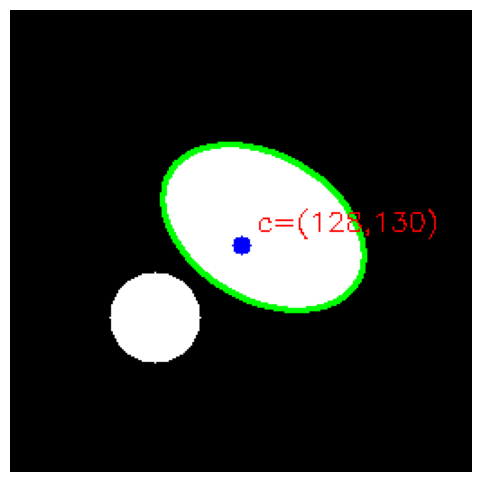

Saved 1 records to m5_features.csv


/tmp/ipython-input-2409323269.py:46: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()


In [11]:
demo_record = run_module5()

Loaded mask 1841_tumor_mask.png shape=(512, 512) dtype=uint8
File: 1841_tumor_mask.png
  Area: 96447.5
  Perimeter: 1184.6732223033905
  Centroid: (263.5821148445822, 221.10109421903746)
Saved visualization to m5_visualizations/1841_tumor_mask_m5_vis.png


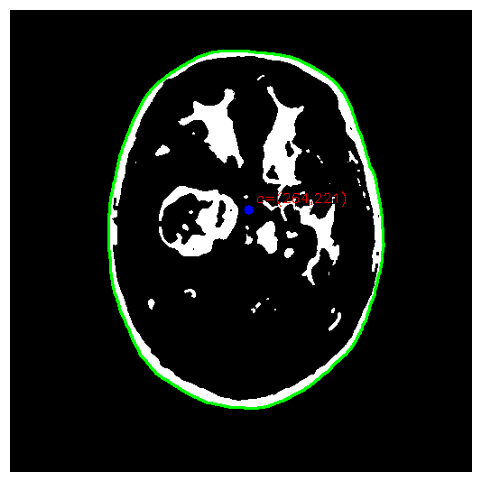

Saved 1 records to m5_features.csv
Saved result for 1841_tumor_mask.png to m5_features.csv


/tmp/ipython-input-3249758115.py:46: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()


{'filename': '1841_tumor_mask.png',
 'area': 96447.5,
 'perimeter': 1184.673,
 'centroid_x': 263.582,
 'centroid_y': 221.101,
 'timestamp': '2025-11-03T10:49:55.726854'}

In [12]:
run_module5(mask_path=Path('/content/drive/MyDrive/kmeans_tumor_masks/Glioma/1841_tumor_mask.png'), visualize=True)

In [13]:
run_module5(batch=True, mask_dir=Path('kmeans_tumor_masks'), output_csv=Path('m5_features.csv'))

Running batch processing on: kmeans_tumor_masks
Mask root not found: kmeans_tumor_masks
